<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/ES/Cleveland_SVM_ES_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleveland Heart Disease - Default SVM vs ES-SVM (RBF)

This notebook loads **ClevlandDataSet.xlsx**, trains Default SVM and ES-SVM, evaluates metrics, plots confusion matrices, ROC curves, ES convergence, saves artifacts (CSV/JSON/PNGs), and exports a standalone HTML app that predicts in-browser.

In [11]:

from __future__ import annotations

import os, json, time, math, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Dict, Tuple

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --------------------------
# User settings / file path
# --------------------------
data_path = 'ClevelandDataSet.xlsx'  # Update path if needed
artifacts_dir = "artifacts"          # Folder to save results
os.makedirs(artifacts_dir, exist_ok=True)

# --------------------------
# Load dataset and basic EDA
# --------------------------
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_excel(path)
    return df

df = load_data(data_path)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (297, 14)


,Age,Sex,CP,Trestbps,Chol,fbs,restecg,Thalach,Exang,Oldpeak,Slop,CA,thal,Class
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [12]:
# --------------------------
# User settings / file path
# --------------------------
# Try both spellings, pick whichever exists
possible_files = ["ClevlandDataSet.xlsx", "ClevelandDataSet.xlsx"]
data_path = next((f for f in possible_files if os.path.exists(f)), None)

if data_path is None:
    raise FileNotFoundError("Neither 'ClevlandDataSet.xlsx' nor 'ClevelandDataSet.xlsx' found in the current directory.")

print(f"Using dataset: {data_path}")

# --------------------------
# Load dataset and basic EDA
# --------------------------
def load_data(path):
    df = pd.read_excel(path)
    return df

df0 = load_data(data_path).dropna(how="all").reset_index(drop=True)

# --------------------------
# Preprocess
# --------------------------
target_col = None
for cand in ["target", "num", "Num", "class", "Class"]:
    if cand in df0.columns:
        target_col = cand
        break
if target_col is None:
    target_col = df0.columns[-1]

y_series = df0[target_col]

# Map Cleveland 'num' to binary if needed (0 vs >0)
if target_col.lower() == "num" or (set(pd.unique(y_series)) - {0,1}):
    y_bin = (y_series.astype(float) > 0).astype(int)
else:
    y_bin = y_series.astype(int)

# Drop ID-like columns
drop_like = [c for c in df0.columns if c.lower() in {"id","index","patientid","pid"}]
X_df = df0.drop(columns=[target_col] + drop_like, errors="ignore")

# Encode categorical features
obj_cols = X_df.select_dtypes(include=["object","category"]).columns.tolist()
if obj_cols:
    X_df = pd.get_dummies(X_df, columns=obj_cols, drop_first=True)

# Final dataset
df = X_df.copy()
df["target"] = y_bin

print("Dataset shape:", df.shape)
df.head(10)


Using dataset: ClevelandDataSet.xlsx
Dataset shape: (297, 14)


,Age,Sex,CP,Trestbps,Chol,fbs,restecg,Thalach,Exang,Oldpeak,Slop,CA,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,1
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,1
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


In [13]:

# Helpers
def is_binary(y: np.ndarray) -> bool:
    return np.unique(y).size == 2

def make_pipeline(C: float = 1.0, gamma="scale") -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, random_state=42))
    ])

def safe_metrics(y_true, y_pred, y_proba=None) -> Dict[str, float]:
    avg = "binary" if is_binary(y_true) else "macro"
    out = {
        "accuracy":  float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, average=avg, zero_division=0)),
        "recall":    float(recall_score(y_true, y_pred, average=avg, zero_division=0)),
        "f1":        float(f1_score(y_true, y_pred, average=avg, zero_division=0)),
    }
    if y_proba is not None and is_binary(y_true):
        out["roc_auc"] = float(roc_auc_score(y_true, y_proba))
    return out

def evaluate_cv_score(X, y, C: float, gamma_val: float, folds: int = 3) -> float:
    scoring = "roc_auc" if is_binary(y) else "accuracy"
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    model = make_pipeline(C=C, gamma=gamma_val)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    return float(np.mean(scores))

@dataclass
class ESState:
    mean: np.ndarray
    sigma: float
    best_score: float
    best_params: np.ndarray
    no_improve: int = 0

BOUNDS = np.array([[-3.0, 3.0], [-4.0, 2.0]])
def clip_to_bounds(x: np.ndarray) -> np.ndarray:
    return np.minimum(np.maximum(x, BOUNDS[:, 0]), BOUNDS[:, 1])

def es_optimize(X, y, iters=10, lam=6, mu=3, patience=3, folds=3, verbose=True):
    rng = np.random.RandomState(42)
    w = np.log(mu + 0.5) - np.log(np.arange(1, mu + 1))
    w = w / np.sum(w)

    state = ESState(mean=np.array([0.0, -1.0]), sigma=0.8,
                    best_score=-np.inf, best_params=np.array([0.0, -1.0]))

    hist = {"gen": [], "best_cv": []}

    for gen in range(1, iters+1):
        Z = rng.randn(lam, 2)
        Y = state.mean + state.sigma * Z
        Y = np.array([clip_to_bounds(yv) for yv in Y])

        scores = np.empty(lam, dtype=float)
        for i, cand in enumerate(Y):
            C = 10.0 ** cand[0]
            gamma_val = 10.0 ** cand[1]
            scores[i] = evaluate_cv_score(X, y, C, gamma_val, folds=folds)

        idx = np.argsort(scores)[::-1][:mu]
        parents, parent_scores = Y[idx], scores[idx]
        new_mean = (w[:, None] * parents).sum(axis=0)

        improved = parent_scores[0] > state.best_score + 1e-8
        state.sigma = float(np.clip(state.sigma * (1.06 if improved else 0.90), 1e-3, 2.5))

        if parent_scores[0] > state.best_score + 1e-10:
            state.best_score  = float(parent_scores[0])
            state.best_params = parents[0]
            state.no_improve  = 0
        else:
            state.no_improve += 1

        state.mean = new_mean
        hist["gen"].append(gen)
        hist["best_cv"].append(state.best_score)

        if verbose:
            print(f"[ES] Gen {gen:02d}/{iters}  best_cv={state.best_score:.4f}  sigma={state.sigma:.3f}  "
                  f"log10C={state.best_params[0]:.3f}  log10gamma={state.best_params[1]:.3f}")

        if state.no_improve >= patience:
            if verbose: print(f"Early stopping (no improvement in {patience} generations).")
            break

    best = {"C": float(10.0 ** state.best_params[0]),
            "gamma": float(10.0 ** state.best_params[1]),
            "cv_score": float(state.best_score)}
    return best, hist


In [14]:

# Train/test and Default SVM
X = df.drop(columns=["target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

default_model = make_pipeline(C=1.0, gamma="scale")
t0 = time.time(); default_model.fit(X_train, y_train); t_def = time.time() - t0

yhat_tr  = default_model.predict(X_train)
yhat_te  = default_model.predict(X_test)
proba_tr = default_model.predict_proba(X_train)[:, 1] if is_binary(y) else None
proba_te = default_model.predict_proba(X_test)[:, 1] if is_binary(y) else None

m_def_tr = safe_metrics(y_train, yhat_tr, proba_tr)
m_def_te = safe_metrics(y_test,  yhat_te, proba_te)

pd.DataFrame([m_def_tr, m_def_te], index=["Default-Train","Default-Test"])


,accuracy,precision,recall,f1,roc_auc
Default-Train,0.907173,0.914286,0.880734,0.897196,0.956494
Default-Test,0.850000,0.880000,0.785714,0.830189,0.954241


In [15]:

# ES-SVM tuning, fit, and combined report
best, es_hist = es_optimize(X_train, y_train, iters=10, lam=6, mu=3, patience=3, folds=3, verbose=True)

es_model = make_pipeline(C=best["C"], gamma=best["gamma"])
t1 = time.time(); es_model.fit(X_train, y_train); t_es = time.time() - t1

yhat_tr_es  = es_model.predict(X_train)
yhat_te_es  = es_model.predict(X_test)
proba_tr_es = es_model.predict_proba(X_train)[:, 1] if is_binary(y) else None
proba_te_es = es_model.predict_proba(X_test)[:, 1] if is_binary(y) else None

m_es_tr = safe_metrics(y_train, yhat_tr_es, proba_tr_es)
m_es_te = safe_metrics(y_test,  yhat_te_es,  proba_te_es)

report = pd.DataFrame([
    {"Model":"Default SVM","Split":"Train", **m_def_tr, "fit_time_sec":round(t_def,3), "C":1.0, "gamma":"scale"},
    {"Model":"Default SVM","Split":"Test",  **m_def_te, "fit_time_sec":round(t_def,3), "C":1.0, "gamma":"scale"},
    {"Model":"ES-SVM","Split":"Train",      **m_es_tr,  "fit_time_sec":round(t_es,3),  "C":best["C"], "gamma":best["gamma"]},
    {"Model":"ES-SVM","Split":"Test",       **m_es_te,  "fit_time_sec":round(t_es,3),  "C":best["C"], "gamma":best["gamma"]},
])
report


[ES] Gen 01/10  best_cv=0.8756  sigma=0.848  log10C=-0.371  log10gamma=-1.373
[ES] Gen 02/10  best_cv=0.8862  sigma=0.899  log10C=-0.053  log10gamma=-2.922
[ES] Gen 03/10  best_cv=0.8862  sigma=0.809  log10C=-0.053  log10gamma=-2.922
[ES] Gen 04/10  best_cv=0.8862  sigma=0.728  log10C=-0.053  log10gamma=-2.922
[ES] Gen 05/10  best_cv=0.8862  sigma=0.772  log10C=-0.217  log10gamma=-2.072
[ES] Gen 06/10  best_cv=0.8862  sigma=0.695  log10C=-0.217  log10gamma=-2.072
[ES] Gen 07/10  best_cv=0.8883  sigma=0.736  log10C=0.473  log10gamma=-3.367
[ES] Gen 08/10  best_cv=0.8885  sigma=0.780  log10C=-0.309  log10gamma=-2.529
[ES] Gen 09/10  best_cv=0.8885  sigma=0.702  log10C=-0.309  log10gamma=-2.529
[ES] Gen 10/10  best_cv=0.8885  sigma=0.632  log10C=-0.309  log10gamma=-2.529


,Model,Split,accuracy,precision,recall,f1,roc_auc,fit_time_sec,C,gamma
0,Default SVM,Train,0.907173,0.914286,0.880734,0.897196,0.956494,0.015,1.000000,scale
1,Default SVM,Test,0.850000,0.880000,0.785714,0.830189,0.954241,0.015,1.000000,scale
2,ES-SVM,Train,0.835443,0.897727,0.724771,0.802030,0.901806,0.014,0.490911,0.002956
3,ES-SVM,Test,0.883333,0.956522,0.785714,0.862745,0.953125,0.014,0.490911,0.002956


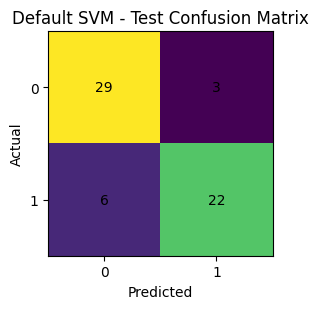

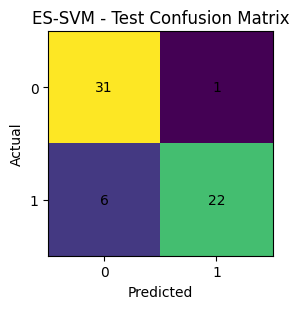

<Figure size 480x360 with 0 Axes>

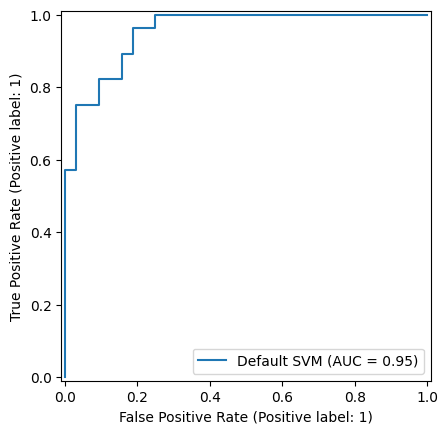

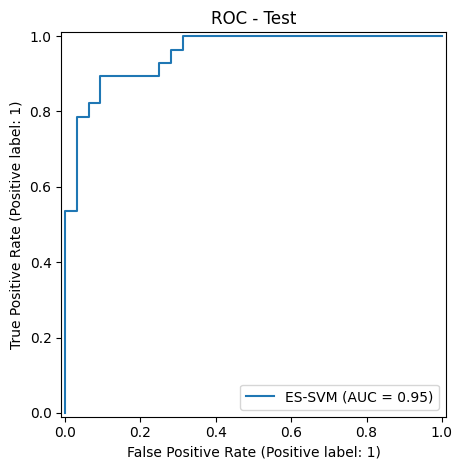

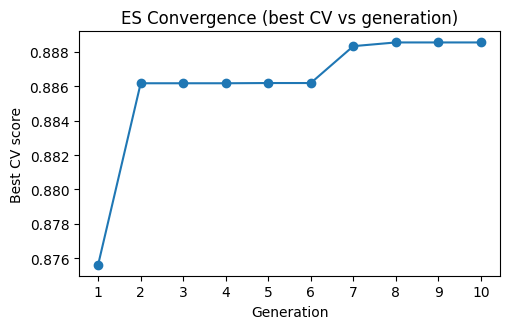

In [16]:

# Plots
def plot_cm(cm, title, path):
    fig, ax = plt.subplots(figsize=(4,3.2))
    im = ax.imshow(cm)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    fig.savefig(path, dpi=160)
    plt.show()

if is_binary(y):
    from sklearn.metrics import confusion_matrix
    cm_def = confusion_matrix(y_test, yhat_te)
    cm_es  = confusion_matrix(y_test, yhat_te_es)
    plot_cm(cm_def, "Default SVM - Test Confusion Matrix", os.path.join(ARTIFACTS_DIR, "cm_default_test.png"))
    plot_cm(cm_es,  "ES-SVM - Test Confusion Matrix",     os.path.join(ARTIFACTS_DIR, "cm_es_test.png"))

    if proba_te is not None:
        fig = plt.figure(figsize=(4.8,3.6))
        RocCurveDisplay.from_predictions(y_test, proba_te, name="Default SVM")
        if proba_te_es is not None:
            RocCurveDisplay.from_predictions(y_test, proba_te_es, name="ES-SVM")
        plt.title("ROC - Test")
        plt.tight_layout()
        fig.savefig(os.path.join(ARTIFACTS_DIR, "roc_test.png"), dpi=160)
        plt.show()

# ES convergence
fig = plt.figure(figsize=(5.2,3.4))
plt.plot(es_hist["gen"], es_hist["best_cv"], marker="o")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Generation"); plt.ylabel("Best CV score")
plt.title("ES Convergence (best CV vs generation)")
plt.tight_layout()
fig.savefig(os.path.join(ARTIFACTS_DIR, "es_convergence.png"), dpi=160)
plt.show()


In [17]:

# Save report and best params
report_path = os.path.join(ARTIFACTS_DIR, "cleveland_svm_es_report.csv")
best_path   = os.path.join(ARTIFACTS_DIR, "cleveland_es_best_params.json")
report.to_csv(report_path, index=False)
with open(best_path, "w") as f:
    json.dump(best, f, indent=2)
print("Saved:")
print(" -", report_path)
print(" -", best_path)


Saved:
 - /cleveland_svm_es_report.csv
 - /cleveland_es_best_params.json


In [18]:

# Export ES-SVM model (scaler + SVM) for browser inference
scaler = es_model.named_steps["scaler"]
svc    = es_model.named_steps["svc"]

export = {
    "feature_names": df.drop(columns=["target"]).columns.tolist(),
    "scaler": {
        "mean": scaler.mean_.tolist(),
        "scale": scaler.scale_.tolist()
    },
    "svm": {
        "kernel": "rbf",
        "gamma": float(svc._gamma if hasattr(svc, "_gamma") else (svc.gamma if isinstance(svc.gamma, float) else 0.1)),
        "support_vectors": svc.support_vectors_.tolist(),
        "dual_coef": svc.dual_coef_.tolist(),
        "intercept": svc.intercept_.tolist(),
        "classes": svc.classes_.tolist()
    }
}
model_json_path = os.path.join(ARTIFACTS_DIR, "Cleveland_ES_SVM_Model.json")
with open(model_json_path, "w") as f:
    json.dump(export, f)
print("Exported model JSON:", model_json_path)


Exported model JSON: /Cleveland_ES_SVM_Model.json


In [19]:

# Build HTML app (no backend). Uses the exported JSON and computes SVM decision in-browser.
html_template = """<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>
<title>Cleveland Heart Disease - ES-SVM Predictor</title>
<style>
  body { font-family: Arial, Helvetica, sans-serif; padding: 20px; max-width: 900px; margin: auto; }
  h1 { font-size: 1.4rem; }
  .grid { display: grid; grid-template-columns: repeat(2, minmax(220px, 1fr)); gap: 12px 18px; }
  label { display:block; font-weight:600; margin-bottom:4px; }
  input { width: 100%; padding: 8px; border-radius: 8px; border: 1px solid #ccc; }
  button { padding: 10px 14px; border-radius: 10px; border: 1px solid #777; background: #f5f5f5; cursor: pointer; }
  .card { border:1px solid #e3e3e3; border-radius:12px; padding:16px; margin-top:18px; box-shadow: 0 2px 6px rgba(0,0,0,0.05); }
  .result { font-size: 1.1rem; font-weight: 700; }
  .muted { color: #666; font-size: 0.9rem; }
</style>
</head>
<body>
  <h1>Cleveland Heart Disease - ES-SVM Predictor</h1>
  <p class="muted">Enter attribute values, then click <b>Predict</b>. Model: RBF SVM (ES-tuned). Output is class 0 (no disease) or 1 (disease).</p>

  <div class="card">
    <div class="grid">
      {{inputs}}
    </div>
    <div style="margin-top:16px">
      <button id="predictBtn">Predict</button>
      <span id="status" class="muted" style="margin-left:10px;"></span>
    </div>
    <div id="output" class="result" style="margin-top:16px;"></div>
  </div>

<script>
async function loadModel() {
  const resp = await fetch('Cleveland_ES_SVM_Model.json');
  if (!resp.ok) throw new Error('Failed to load model JSON');
  return await resp.json();
}

function rbfKernel(x, sv, gamma) {
  let sum = 0.0;
  for (let i=0;i<x.length;i++) {
    const d = x[i] - sv[i];
    sum += d*d;
  }
  return Math.exp(-gamma * sum);
}

function decisionFunction(x, model) {
  const gamma = model.svm.gamma;
  const SV = model.svm.support_vectors;
  const dual = model.svm.dual_coef[0];
  const b = model.svm.intercept[0];
  let f = 0.0;
  for (let i=0;i<SV.length;i++) {
    const k = rbfKernel(x, SV[i], gamma);
    f += dual[i] * k;
  }
  f += b;
  return f;
}

function standardize(x_raw, mean, scale) {
  const out = new Array(x_raw.length);
  for (let i=0;i<x_raw.length;i++) out[i] = (x_raw[i] - mean[i]) / scale[i];
  return out;
}

document.getElementById('predictBtn').addEventListener('click', async () => {
  const status = document.getElementById('status');
  const output = document.getElementById('output');
  try {
    status.textContent = 'Loading model...';
    const model = await loadModel();
    const featureNames = model.feature_names;
    const mean = model.scaler.mean;
    const scale = model.scaler.scale;
    const inputs = [];
    for (const name of featureNames) {
      const el = document.getElementById(name);
      const v = parseFloat(el.value);
      if (Number.isNaN(v)) throw new Error('Please fill all inputs with numeric values.');
      inputs.push(v);
    }
    const xz = standardize(inputs, mean, scale);
    const f = decisionFunction(xz, model);
    const cls = f >= 0 ? model.svm.classes[1] : model.svm.classes[0];
    output.textContent = 'Prediction: ' + cls;
    status.textContent = 'Done.';
  } catch (err) {
    output.textContent = '';
    status.textContent = 'Error: ' + err.message;
  }
});
</script>
</body>
</html>
"""

features = df.drop(columns=["target"]).columns.tolist()
inputs_html = "".join([f'<div><label for="{fn}">{fn}</label><input id="{fn}" type="number" step="any" /></div>' for fn in features])
html_content = html_template.replace("{{inputs}}", inputs_html)

html_path = os.path.join(ARTIFACTS_DIR, "Cleveland_SVM_ES_App.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print("Wrote HTML app to:", html_path)


Wrote HTML app to: /Cleveland_SVM_ES_App.html


In [20]:

# Export all code cells as a JSON file (for reproducibility / sharing)
export_code = []
for cell in _ih:  # _ih contains the input history in many Jupyter environments
    if isinstance(cell, str) and cell.strip().startswith(('#','from ','import ','def ','class ','@')):
        export_code.append(cell)

code_json_path = os.path.join(ARTIFACTS_DIR, "Cleveland_SVM_ES_Code.json")
with open(code_json_path, "w") as f:
    json.dump({"cells_code_history": export_code}, f, indent=2)
print("Exported code history JSON to:", code_json_path)


Exported code history JSON to: /Cleveland_SVM_ES_Code.json
